* Resumo:
  - Desenvolvimento de um modelo yolo, de visão computacional, para detecção do instante anterior à batida de pênalti.

* Descrição do problema
  - A partir da exploração de modelos de visão computacional para detecção de momentos no futebol, não há uma grande quantidade disponível. Quando se trata apenas do pênalti, tal valor é reduzido ainda mais, portanto, o atual trabalho visa desenvolver um modelo de visão computacional para atuar em um dos momentos mais cruciais de uma partida de futebol. Tal modelo terá como tarefa a classificação do instante imaediatamente anterior à batida de penalti, dado uma imagem como entrada.
  
* Descrição da metodologia aplicada
  - Coletar os dados através de vídeos;
  - Importar os vídeos para o ambiente de desenvolvimento;
  - Transformar os vídeos em imagens;
  - Segmentar as imagens em:
    - datasets de treino, validação e teste;
    - classificar manualmente em yes (momento antes do chute) ou 0 (caso contrário);
  - Treinar o modelo Yolo versão 8;
  - Analisar os resultados de treino e validação;
  - Testar o modelo com imagens e vídeos;

* Dados
  - Os dados foram gerados a partir de meus vídeos realizando cobranças de pênaltis.

* Resultados obtidos:
  - De acordo com a matriz de confusão de treinamento, é possível notar que o modelo acertou a maioria das classes, errando apenas 12% para os falsos negativos.
<img src="data/runs/classify/train/confusion_matrix_normalized.png" alt="Matriz de confusão do treinamento" style="height: 500px; width:700px;"/>

* Conclusão
  - O modelo é capaz de classificar os momentos verdadeiros com exatidão. Além disso, o modelo foi utilizado em imagens, assim como, em vídeos, logo, tornando-se elegível à detcçao em tempo real. 

* Referências
  - https://github.com/FSaeta/Explorando-a-captacao-de-movimento-dos-jogadores-de-futebol-em-cobrancas-de-penaltis
  - https://blog.roboflow.com/track-football-players/

## Código

### Instalando dependencias
- pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118
- pip install ultralytics ipykernel moviepy

Checar o cuda

In [17]:
import torch
torch.cuda.is_available()

True

## Convertendo os videos para imagens

In [16]:
# trocando o diretório atual
import os
path = '/home/rafaa/pmy/penalty_project'
os.chdir(path)
print(os.getcwd())

/home/rafaa/pmy/penalty_project


In [ ]:
import subprocess,os,glob
from IPython.display import Video
from moviepy.editor import *

def get_file_extension_from_filepath(filepath): return filepath.split('.')[-1]
def get_filename_from_filepath(filepath): return filepath.split('/')[-1].split('.')[0]

def get_video_fps(filepath):
    # Get the original frame rate using ffprobe
    ffprobe_cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=r_frame_rate",
        "-of", "default=noprint_wrappers=1:nokey=1",
        filepath
    ]
    # Run ffprobe to get the frame rate
    result = subprocess.run(ffprobe_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    original_fps = result.stdout.strip()
    return original_fps

def convert_video_to_images(filepath, paths):
    filename = get_filename_from_filepath(filepath)
    original_fps = get_video_fps(filepath)
    # original_fps=1
    folder = f"{paths['images']}/{filename}"
    os.makedirs(folder,exist_ok=True)
    output_image_pattern = f"{folder}/{filename}_%04d.jpg"  # Adjust output pattern as needed

    # Define FFmpeg command to convert MXF to images
    ffmpeg_cmd = [
        "ffmpeg",
        "-y",               # Automatically overwrite output files
        "-i", filepath,
        "-vf", f"fps={original_fps}",  # Set output frame rate
        '-q:v', '0',             # Output quality (0 - 31, 2 is a good default)
        '-qmin', '1',            # Minimum quantization value
        '-qmax', '31',           # Maximum quantization value
        output_image_pattern
    ]

    subprocess.run(ffmpeg_cmd, check=True)
    print("Conversion complete")

# set folders and create them if needed
data_path =  f'data'
paths = {
    'videos':f'{data_path}/videos',
    'images':f'{data_path}/images',
    }
for p in paths.values(): os.makedirs(p,exist_ok=True)
videos = glob.glob(f"{paths['videos']}/*")
for video in videos:
    print(get_video_fps(video))
    # convert_video_to_images(video, paths) # debug

## Análise
 Após analisar imagem por imagem, tagea-se as images da seguinte forma:
- yes, se a imagem corresponde ao momento imediatamente anterior ao chute
- no, caso contrário 

Além disso, a partir dos 14 videos, e seguindo a proporção de 
- 80%(treino) = 12 videos
- 10%(validação) = 1 video ok
- 10%(teste) = 1 video 

#### Lista de comandos para dividir as imagens nos diretórios 
listar os positivos antes de mover
```
for i in $(seq -f "%04g" 80 88); do ls "data/images/IMG_5360/IMG_5360_$i.jpg"; done
```

mover os positivos   
```
for i in $(seq -f "%04g" 80 88); do mv "data/images/IMG_5360/IMG_5360_$i.jpg" "data/dataset/train/yes/"; done
```

mover os negativos
```
mv data/images/IMG_5360/* data/dataset/train/no/
```

remover a pasta
```
rm -r data/images/IMG_5360
```



## Plotando os frames de um video

In [ ]:
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

DEBUG = 0
cap = cv.VideoCapture(video)

# Check if the video file is opened successfully
if not cap.isOpened(): 
    print("Error: Could not open video file.")
    # return
    print('error') 

# Get the video codec and properties from the input video 
fps = int(cap.get(cv.CAP_PROP_FPS))
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

total_duration = frame_count / fps 
print(f"Video (sec): {0}-{round(total_duration,2)}")
print(f"Frames: {0}-{frame_count}")

frame_number=0
cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
while(True):
    ret, frame = cap.read()
    if not ret:
        print(f"Error reading frame {frame_number}")
        break
    
    # Get the timestamp (time in ms) of the frame
    frame_time = int(cap.get(cv.CAP_PROP_POS_MSEC))

    # # # plot the predicted image
    im = Image.fromarray(frame[..., ::-1])  # RGB PIL image
        
    # show img
    plt.imshow(im)
    plt.title(f"Frame {frame_number} - {round(frame_time,5)} ms")
    plt.axis('off')
    plt.show()
        
    if(DEBUG): break

cap.release()

## Treinando o modelo YOLO V8
editar o arquivo de configurações, de acordo com os valores abaixo:
```
# /home/rafaa/.config/Ultralytics/settings.yaml
datasets_dir: /home/rafaa/pmy/penalty_project/data
weights_dir: /home/rafaa/pmy/penalty_project/data/weights
runs_dir: /home/rafaa/pmy/penalty_project/data/runs
```

In [ ]:
from IPython.display import display
from PIL import Image
from ultralytics import YOLO
import os

# change current folder
print(os.getcwd())
if 'data' not in os.getcwd():
    os.makedirs('data/dataset',exist_ok=True) # criar diretorio
    os.chdir('data')
print(os.getcwd())

Realizando o treinamento com GPU

In [ ]:
model = YOLO('yolov8n-cls.pt')
results = model.train(
    data='dataset',
    epochs=100,
    imgsz=640,
    verbose=True,
    device=0)

# Inferindo

## Imagem

In [ ]:
from IPython.display import display
from PIL import Image
from ultralytics import YOLO
import os

# change current folder
os.chdir('/home/rafaa/pmy/penalty_project/data')
best_model_path = 'runs/classify/train4/weights/best.pt'
path = "/home/rafaa/pmy/penalty_project/data/images/IMG_5369/IMG_5369_0010.jpg"

# Load the model
model = YOLO(best_model_path)

# inference
r = model(path,save=False, conf=0.15, iou=0.1,device='0')[0]

# Show the results
im_array = r.plot(conf=True)  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

# Tratando o resultado
classes_names = r.names
probs = r.cpu().probs.data.tolist()
classes_probs = {}
for k,v in classes_names.items(): classes_probs[v] = round(probs[k],2)
print("Results : ", classes_probs)


## frames de um Video


0: 640x640 no 0.93, yes 0.07, 2.8ms
Speed: 4.5ms preprocess, 2.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


Video (sec): 0-4.1
Frames: 0-119


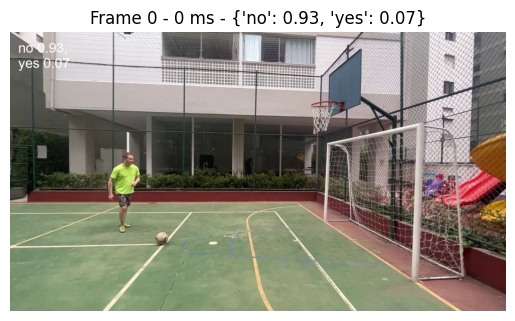

In [15]:
from IPython.display import display
from PIL import Image
from ultralytics import YOLO
import os
import cv2 as cv
import matplotlib.pyplot as plt

# change current folder
os.chdir('/home/rafaa/pmy/penalty_project/data')
best_model_path = 'runs/classify/train4/weights/best.pt'
path = 'videos/IMG_5358.MOV'

# Load the model
model = YOLO(best_model_path)
DEBUG = 1

cap = cv.VideoCapture(path)

# Check if the video file is opened successfully
if not cap.isOpened(): 
    print("Error: Could not open video file.")
    # return
    print('error') 

# Get the video codec and properties from the input video 
fps = int(cap.get(cv.CAP_PROP_FPS))
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
total_duration = frame_count / fps 
print(f"Video (sec): {0}-{round(total_duration,2)}")
print(f"Frames: {0}-{frame_count}")

frame_number=0
cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
while(True):
    ret, frame = cap.read()
    if not ret:
        print(f"Error reading frame {frame_number}")
        break
    
    # Get the timestamp (time in ms) of the frame
    frame_time = int(cap.get(cv.CAP_PROP_POS_MSEC))

    # inference
    r = model(frame,save=False, conf=0.15, iou=0.1,device='0')[0]

    classes_names = r.names
    probs = r.cpu().probs.data.tolist()
    classes_probs = {}
    for k,v in classes_names.items(): classes_probs[v] = round(probs[k],2)

    # # # plot the predicted image
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
        
    # show img
    plt.imshow(im)
    plt.title(f"Frame {frame_number} - {round(frame_time,5)} ms - {classes_probs}")
    plt.axis('off')
    plt.show()

    frame_number+=1
    # if(DEBUG == 1 and frame_number==1): break

cap.release()